In [1]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Open data obtain from roboflow (csv tensorflow)

In [3]:
test=pd.read_csv('test/_annotations.csv')
train=pd.read_csv('train/_annotations.csv')
valid=pd.read_csv('valid/_annotations.csv')

test.head()

Create image and resizing bacteria (to have equal size of matrix). The image must be flatten and converted into list to have correct dimensions for model

In [4]:
def crop_image (image_path, xmin, xmax, ymin, ymax):
        im=cv.imread(image_path)
        crop_img=im[ymin:ymax, xmin:xmax]
        resize= cv.resize(crop_img, (10,10),interpolation=cv.INTER_AREA).flatten()
        return resize.tolist()

Obtaining X and Y data for model. This model will be cyanobacteria (0) - not cyanobacteria (1)

In [6]:
X_test=[]
Y_test=[]
for index,row in test.iterrows():
    X_test.append(crop_image('test/'+str(row['filename']),row['xmin'],row['xmax'],row['ymin'],row['ymax']))
    if row['class']=='cyanobacteria':
        Y_test.append(0)
    else:
        Y_test.append(1)

    

Same for train and validation data

In [7]:
X_train=[]
Y_train=[]
for index,row in train.iterrows():
    try:
        X_train.append(crop_image('train/'+str(row['filename']),row['xmin'],row['xmax'],row['ymin'],row['ymax']))
        if row['class']=='cyanobacteria':
            Y_train.append(0)
        else:
            Y_train.append(1)
    except:
        pass
len(X_train)

3072

In [8]:
X_valid=[]
Y_valid=[]
for index,row in valid.iterrows():
    try:
        X_valid.append(crop_image('valid/'+str(row['filename']),row['xmin'],row['xmax'],row['ymin'],row['ymax']))
        if row['class']=='cyanobacteria':
            Y_valid.append(0)
        else:
            Y_valid.append(1)
    except:
        pass
len(X_valid)

303

List are converted into numpy arrays

In [9]:
X_test=np.array(X_test)
Y_test=np.array(Y_test)
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_valid=np.array(X_valid)
Y_valid=np.array(Y_valid)

What we are here: Use kNN to predict cyanobacteria (without data augmentation), k between 1 and 50

In [10]:
from sklearn import metrics

In [17]:
range_k = range(1,40)
scores = {}
scores_list = []
for k in range_k:   
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, Y_train)
    y_pred = classifier.predict(X_test)
    scores[k] = metrics.accuracy_score(Y_test,y_pred)
    scores_list.append(metrics.accuracy_score(Y_test,y_pred))

Plot to see k with best acurracy

Text(0, 0.5, 'Accuracy')

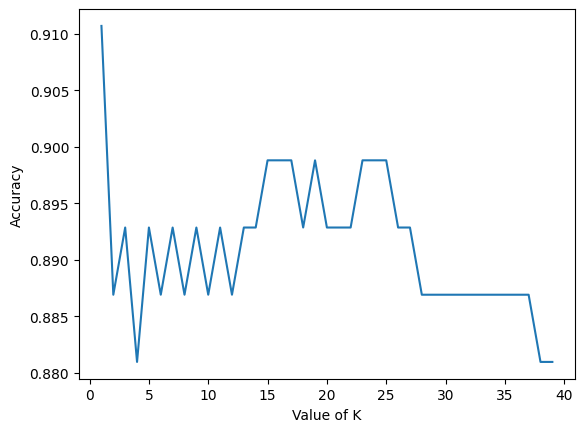

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range_k,scores_list)
plt.xlabel("Value of K")
plt.ylabel("Accuracy")

As k=16 has best acurracy

In [19]:
classifier = KNeighborsClassifier(n_neighbors = 40)
classifier.fit(X_train, Y_train)
y_pred = classifier.predict(X_test)

**Testing**

Confunsion matrix and Classification report is calculated

In [20]:
result = metrics.confusion_matrix(Y_test, y_pred)
print("Confusion Matrix:")
print(result)
result1 = metrics.classification_report(Y_test, y_pred)
print("Classification Report:",)
print (result1)

Confusion Matrix:
[[142   0]
 [ 20   6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       142
           1       1.00      0.23      0.38        26

    accuracy                           0.88       168
   macro avg       0.94      0.62      0.65       168
weighted avg       0.90      0.88      0.85       168



In [21]:
result = metrics.confusion_matrix(Y_test, y_pred)
print("Confusion Matrix:")
print(result)
result1 = metrics.classification_report(Y_test, y_pred)
print("Classification Report:",)
print (result1)

Confusion Matrix:
[[142   0]
 [ 20   6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       142
           1       1.00      0.23      0.38        26

    accuracy                           0.88       168
   macro avg       0.94      0.62      0.65       168
weighted avg       0.90      0.88      0.85       168



Also RMSE, R2 and Cross validation is calculated

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
print("RMSE DT:",np.sqrt(mean_squared_error(Y_test, y_pred)))
print("R2 DT:",r2_score(Y_test, y_pred))
predictions = np.mean(cross_validate(classifier,X_test,Y_test,cv=100)['test_score'])
print('The accuracy is (cross validation*100): ',predictions*100,'%')

RMSE DT: 0.3450327796711771
R2 DT: 0.08992416034669559
The accuracy is (cross validation*100):  87.0 %


c:\Users\ccana\Documents\Python-Environment\Main_Env\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 26 members, which is less than n_splits=100.
  warnings.warn(


ROC curve and AUC are calculated

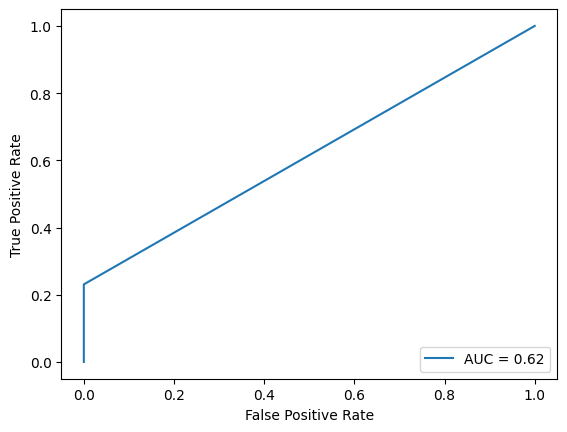

In [23]:
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(Y_test, y_pred)
roc_pls = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr))
roc_pls.plot()
plt.show()

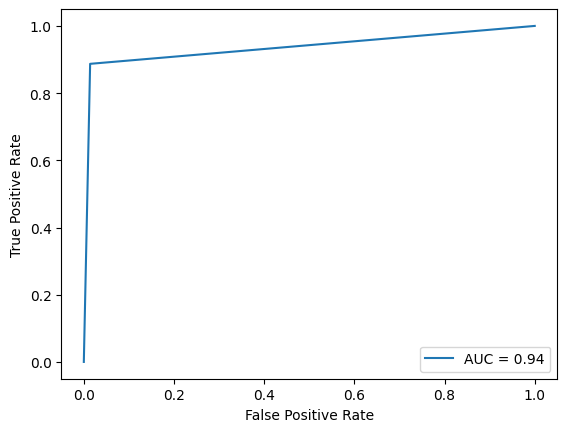

In [14]:
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(Y_test, y_pred)
roc_pls = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr))
roc_pls.plot()
plt.show()

**Validation**

In [15]:
y_valid=classifier.predict(X_valid)

Classification report.
1. Confusion matrix, presicion, recall and f1-score

In [16]:
result = metrics.confusion_matrix(Y_valid, y_valid)
print("Confusion Matrix:")
print(result)
result1 = metrics.classification_report(Y_valid, y_valid)
print("Classification Report:",)
print (result1)

Confusion Matrix:
[[233   9]
 [ 37 334]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       242
           1       0.97      0.90      0.94       371

    accuracy                           0.92       613
   macro avg       0.92      0.93      0.92       613
weighted avg       0.93      0.92      0.93       613



2. RMSE, R2 and Cross Validation

In [17]:
print("RMSE DT:",np.sqrt(mean_squared_error(Y_valid, y_valid)))
print("R2 DT:",r2_score(Y_valid, y_valid))
predictions = np.mean(cross_validate(classifier,X_valid,Y_valid,cv=100)['test_score'])
print('Cross Validation:', predictions)
print('The accuracy is: ',predictions*100,'%')

RMSE DT: 0.2739357279258362
R2 DT: 0.6859281370430599
Cross Validation: 0.9130952380952381
The accuracy is:  91.30952380952381 %


3.ROC curve and AUC value

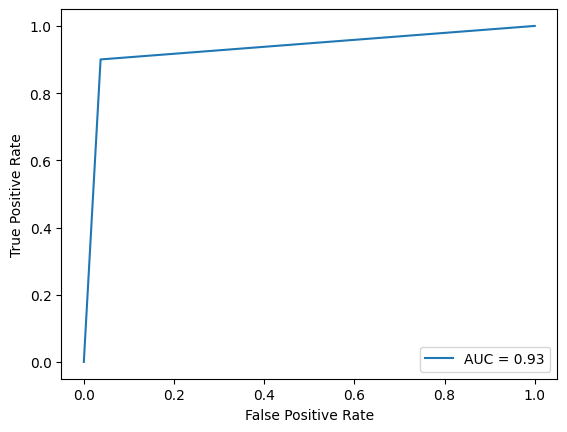

In [18]:
fpr, tpr, _ = roc_curve(Y_valid, y_valid)
roc_pls = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr))
roc_pls.plot()
plt.show()

**Results (counting)**
1. Testing

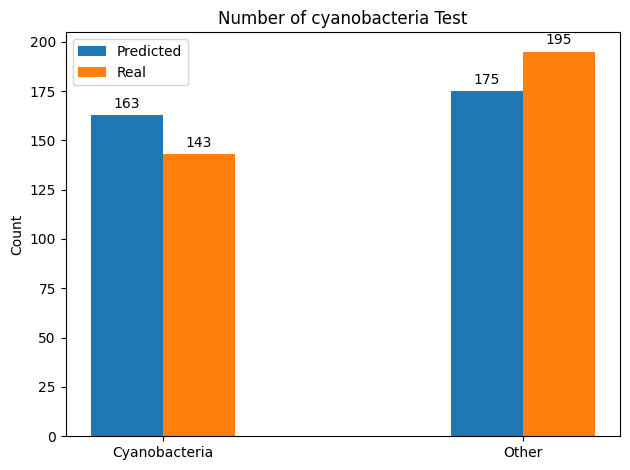

In [33]:
y_pred_list= y_pred.tolist()
Y_test_list=Y_test.tolist()

labels = ['Cyanobacteria', 'Other']
predicted = [y_pred_list.count(0),y_pred_list.count(1)]
real=[Y_test_list.count(0),Y_test_list.count(1)]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, predicted, width, label='Predicted')
rects2 = ax.bar(x + width/2, real, width, label='Real')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Number of cyanobacteria Test')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

2. Validation

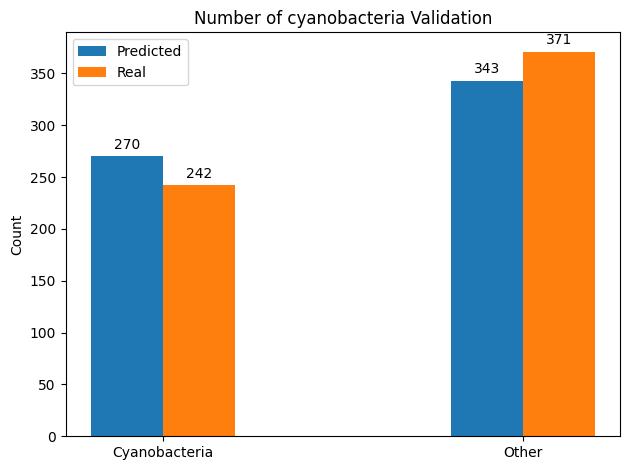

In [32]:
y_valid_list= y_valid.tolist()
Y_valid_list=Y_valid.tolist()

labels = ['Cyanobacteria', 'Other']
predicted_v = [y_valid_list.count(0),y_valid_list.count(1)]
real_v=[Y_valid_list.count(0),Y_valid_list.count(1)]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, predicted_v, width, label='Predicted')
rects2 = ax.bar(x + width/2, real_v, width, label='Real')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Number of cyanobacteria Validation')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()